In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Please use `cd` command to change the directory to the folder containing this notebook file.

In [2]:
cd /content/drive/MyDrive/CIS5810/Project2_Canny_Edge_Detection/

/content/drive/MyDrive/CIS5810/Project2_Canny_Edge_Detection


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import signal
from PIL import Image
import argparse

# TODO: Copy the path of the folder that contains this notebook using the file navigation on the left:
# Ex. /content/drive/MyDrive/CIS5810/Project_2_Canny_Edge
sys.path.append('/content/drive/MyDrive/CIS5810/Project2_Canny_Edge_Detection')

# import functions
from helpers import *

# Tests and Visualization

In [4]:
'''
Test output correctness. Do not modify
'''
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    if test_pass:
      print('Shape Test Passed! \n')
    else:
      print('Shape Test Failed! \n')

    return test_pass

In [5]:
'''
  Derivatives visualzation function. Do not modify
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))
    Ori = np.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )
    


'''
  Edge detection result visualization function. Do not modify
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

# Functions

In [6]:
'''
  Convert RGB image to gray one manually. Do not modify
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

In [7]:
from scipy.signal.filter_design import math
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    #Filter defintions

    G = np.array([[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]])/159.0 #Gaussian kernel
    dx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) #np.gradient(G,axis=1)#derivative in x
    dy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) #np.gradient(G,axis=0)#derivative in y

    #Convolution of Gaussian with derivatives
    Gx = signal.convolve2d(G,dx,mode='same') #G convolved with dx
    Gy = signal.convolve2d(G,dy,mode='same')#G convolved with dy

    #Convolution of image with Gx and Gy (image gradient in x direciton and y direciton, respectively)

    Magx = signal.convolve2d(I_gray,Gx,mode='same')
    Magy = signal.convolve2d(I_gray,Gy,mode='same')

    #magnitude

    Mag = np.sqrt(np.add(np.multiply(Magx,Magx),np.multiply(Magy,Magy)))

    #orientation 
      #hint: see week 2 slide #84 for how to compute the ori - numpy will be helpful (https://numpy.org/doc/stable/reference/ufuncs.html)
    
    Ori = np.arctan2(Magy,Magx)

    return Mag, Magx, Magy, Ori

In [8]:
## Test ##
# you may need to change the path to I1.jpg under Images folder
I = plt.imread('Images/I1.jpg')
Mag, Magx, Magy, Ori = findDerivatives(I)
assert np.allclose(Mag, np.load('Mag.npy'))
assert np.allclose(Magx, np.load('Magx.npy'))
assert np.allclose(Magy, np.load('Magy.npy'))
assert np.allclose(Ori, np.load('Ori.npy'))

In [10]:
def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the magnitude of derivatives
        - Input Ori: H x W matrix represents the orientation of derivatives
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    # getting neighbor in the oritention direction

    # using interpolation to get neighbor
    
    # getting neighbor in the opposite of the oritention direction
    
    # perform NMS
    #Meshgrid 
    
    nc = Mag.shape[1]
    nr = Mag.shape[0]

    # Mag = np.pad(Mag,((1,1),(1,1)),'constant')
    # Ori = np.pad(Ori,((1,1),(1,1)),'constant')
    # print(Mag)

    x,y = np.meshgrid(np.arange(nc),np.arange(nr))

    x_neighbor = x+np.cos(Ori)
    y_neighbor = y+np.sin(Ori)
    # print(x_neighbor.shape)
    # print(y_neighbor.shape)
    Ori1= Ori +np.pi
 
    #neigbors in the other orientation direction

    x_neighbor2 = x+np.cos(Ori1)
    y_neighbor2 = y+np.sin(Ori1)
    
    
    # print(x_neighbor2.shape)
    # print(y_neighbor2.shape)
    
    # using interpolation to get neighbor

    neighbor1 = interp2(Mag, x_neighbor, y_neighbor)
    neighbor2 = interp2(Mag, x_neighbor2, y_neighbor2)

    neighbor1[np.around(y_neighbor)<0] = 0
    neighbor1[np.around(y_neighbor)>nr-1] = 0
    neighbor1[np.around(x_neighbor)<0] = 0
    neighbor1[np.around(x_neighbor)>nc-1] = 0

    neighbor2[np.around(y_neighbor2)<0] = 0
    neighbor2[np.around(y_neighbor2)>nr-1] = 0
    neighbor2[np.around(x_neighbor2)<0] = 0
    neighbor2[np.around(x_neighbor2)>nc-1] = 0

    # print(neighbor1)
    # print(neighbor2)

    
    # perform NMS - pseudo code below

    #2 - Vectorized
    # Mag >= neighbor1 & Mag >=neighbor2
    M = np.logical_and(Mag >= neighbor1 , Mag >=neighbor2)
    
    return M

In [11]:
## Test ##
Mag = np.array([[0, 2, 12, 16],
                [4, 9, 11, 8],
                [7, 17, 12, 9],
                [0, 19, 21, 17]])
Ori = np.array([[np.pi/2, np.pi/4,       0, np.pi/4],
                [np.pi/4, np.pi/4, np.pi/4, np.pi/2],
                [np.pi/4,       0, np.pi/2, np.pi/4],
                [np.pi/2, np.pi/4, np.pi/2, np.pi/4]])

res = np.array([[False, False, False,  True],
                [False, False,  True, False],
                [False,  True, False, False],
                [False,  True,  True,  True]])

M = nonMaxSup(Mag, Ori)

assert M.dtype == bool
assert M.shape == Mag.shape
assert np.allclose(M, res)

In [12]:
'''
Canny edge detection main function. Do not modify
'''
def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)
    # Find gradient and perform NMS and edge linking
    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)

    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)
        plt.show()

    return E

## Simple image test cases
First, let's visualize the some simple images and their detected edges as shown below. 

Text(0.5, 1.0, 'Checkerboard edges')

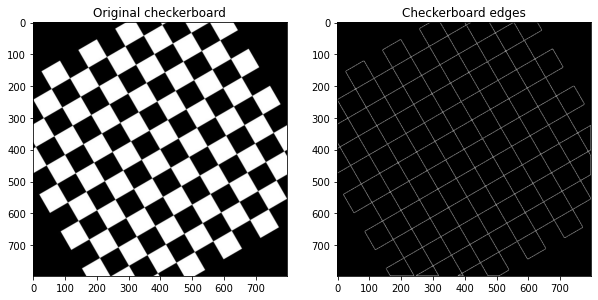

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
I_checkerboard = plt.imread('Test_Images/rotated_checkerboard.jpg')
I_checkerboard_result = plt.imread('Test_Images/rotated_checkerboard_Result.png')
ax1.imshow(I_checkerboard, cmap='gray')
ax1.set_title('Original checkerboard')
ax2.imshow(I_checkerboard_result, cmap='gray')
ax2.set_title('Checkerboard edges')

Text(0.5, 1.0, 'Coins edges')

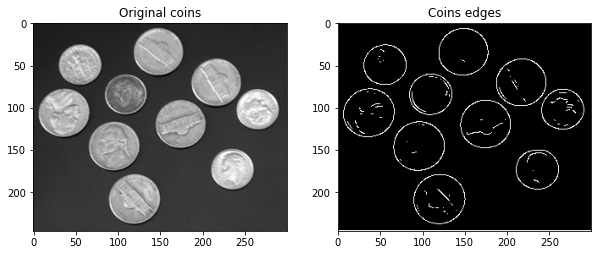

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
I_coin = plt.imread('Test_Images/coins.png')
I_coin_result = plt.imread('Test_Images/coins_Result.png')
ax1.imshow(I_coin, cmap='gray')
ax1.set_title('Original coins')
ax2.imshow(I_coin_result, cmap='gray')
ax2.set_title('Coins edges')

Now, let's try to generate the edges result for both checkerboard and coins images using your implemented functions. To start, remember to create a folder with name *Results* under the same directory of this notebook so that the generated images can be properly saved into it.

Shape Test Passed! 



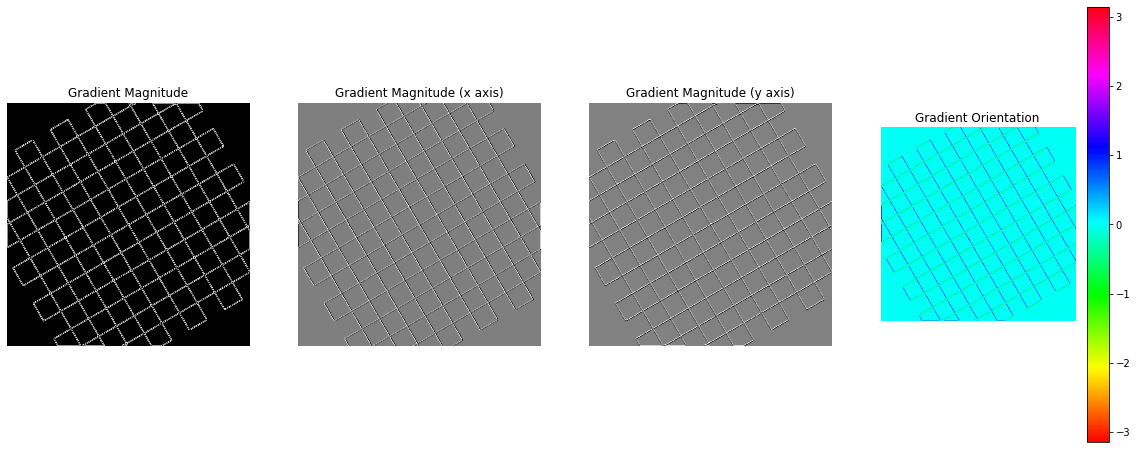

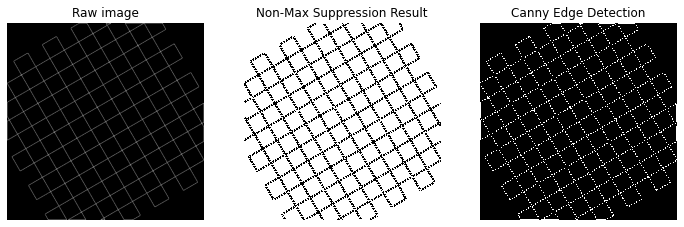

In [15]:
# tuning threshold for simple test images
image_folder = "Test_Images"
save_folder = "Results" # need to create this folder in the drive
filename='rotated_checkerboard_Result.png' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 10, 50
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

## Tune the threshold for all images under "Image" folder
In this part, we are trying to find out the proper low and high threshold values for all images under the *Images* folder. You can execute the code cell below to print out all image file names. 

To find out each image's best possible low and high threshold value, you can iteratively change the filename and try different low and high threshold values. The Canny edge results would be visualized for your reference to determine whether your entered threshold value is good or not. After you find a proper threshold value for one image, remember to fill it in `thresh_dict` dictionary for final image save.

In [16]:
 # list all image names
 os.listdir('Images')

['189080.jpg',
 '16068.jpg',
 '118035.jpg',
 '48017.jpg',
 'I1.jpg',
 '86000.jpg',
 '201080.jpg',
 '21077.jpg',
 '22013.jpg',
 '3096.jpg',
 '55067.jpg',
 '135069.jpg']

Shape Test Passed! 



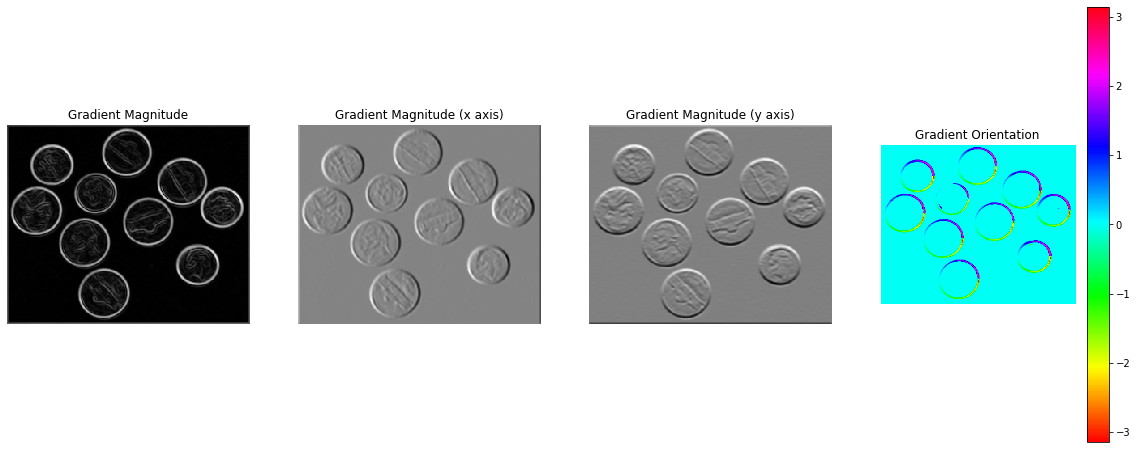

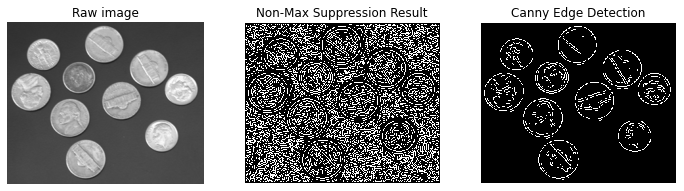

In [ ]:
# Find tuning threshold for a single image
image_folder = "Test_Images"
save_folder = "Results" # need to create this folder in the drive
filename = 'coins.png' # TODO: change image name 
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
low, high = 18, 45 # TODO: Enter possible low and high threshold value
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')

# Fill in all tuned threshold to generate edge detection results


Shape Test Passed! 



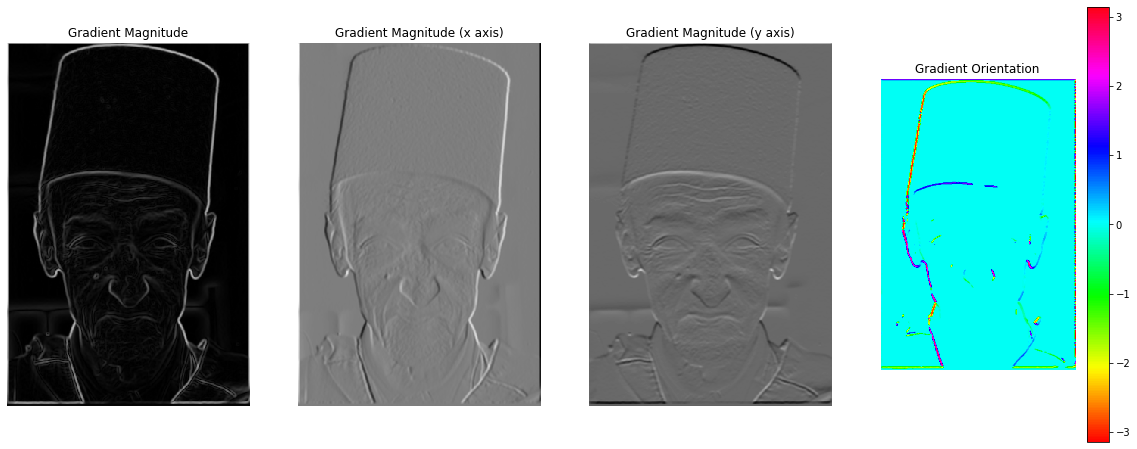

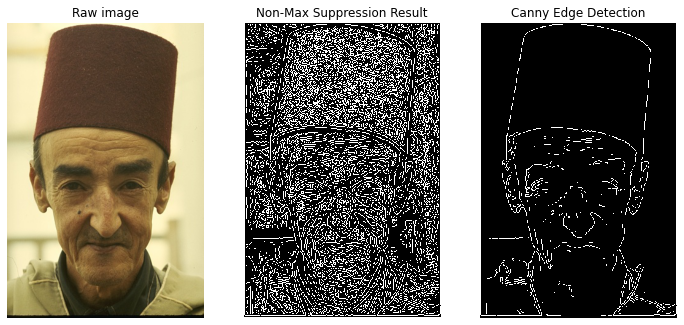

Shape Test Passed! 



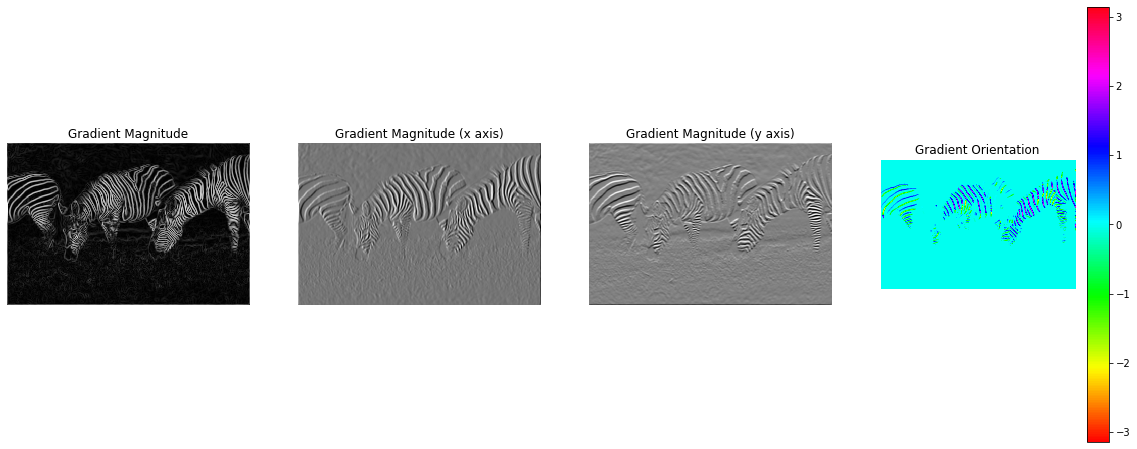

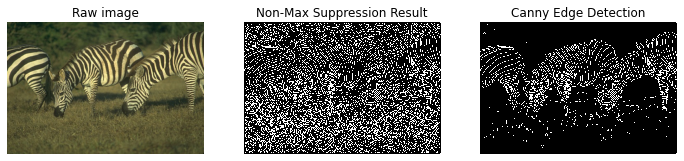

Shape Test Passed! 



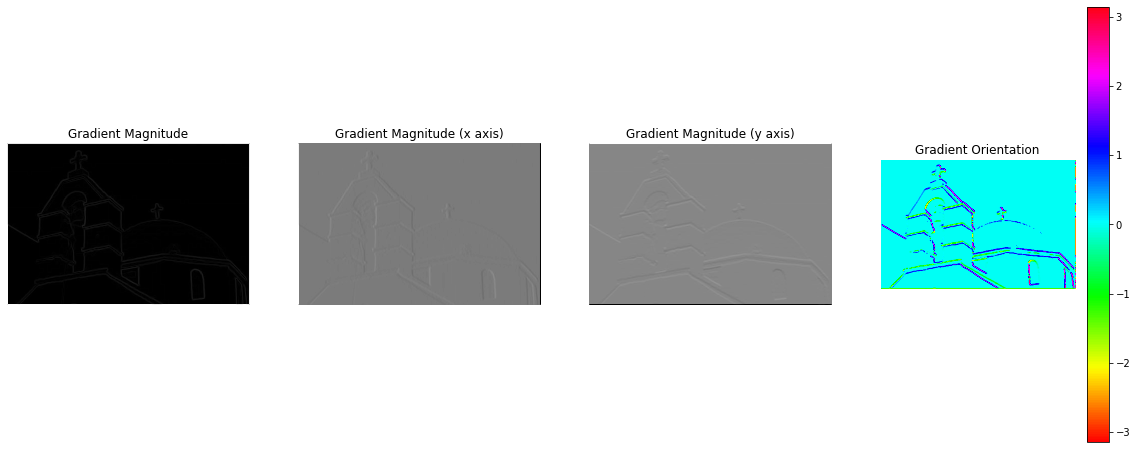

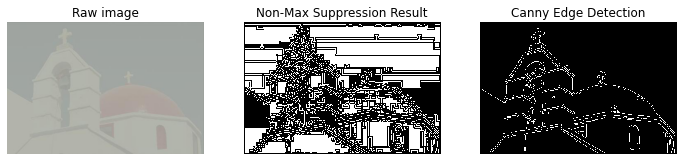

Shape Test Passed! 



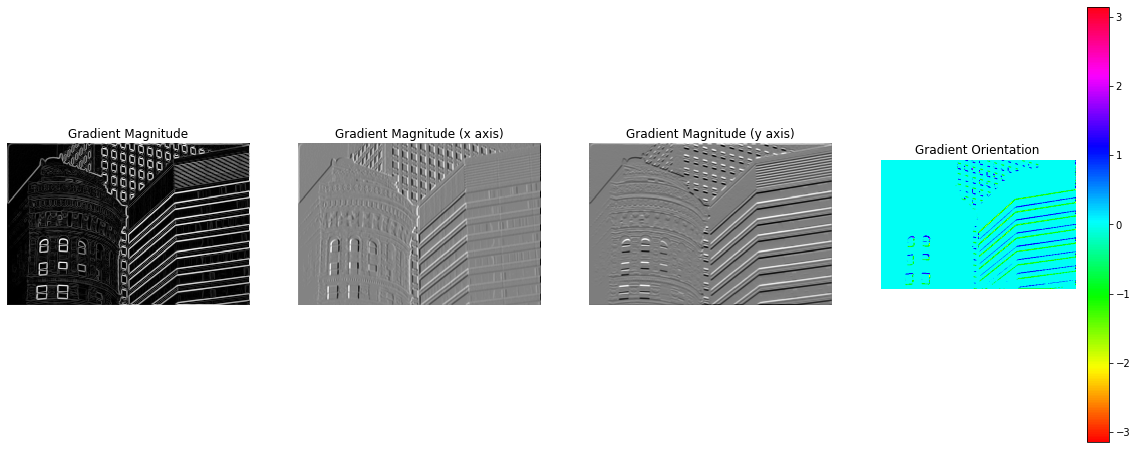

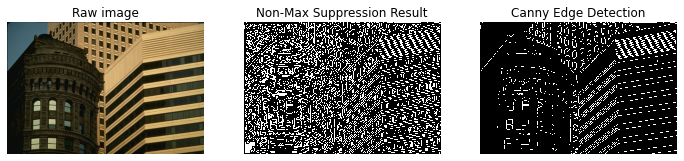

Shape Test Passed! 



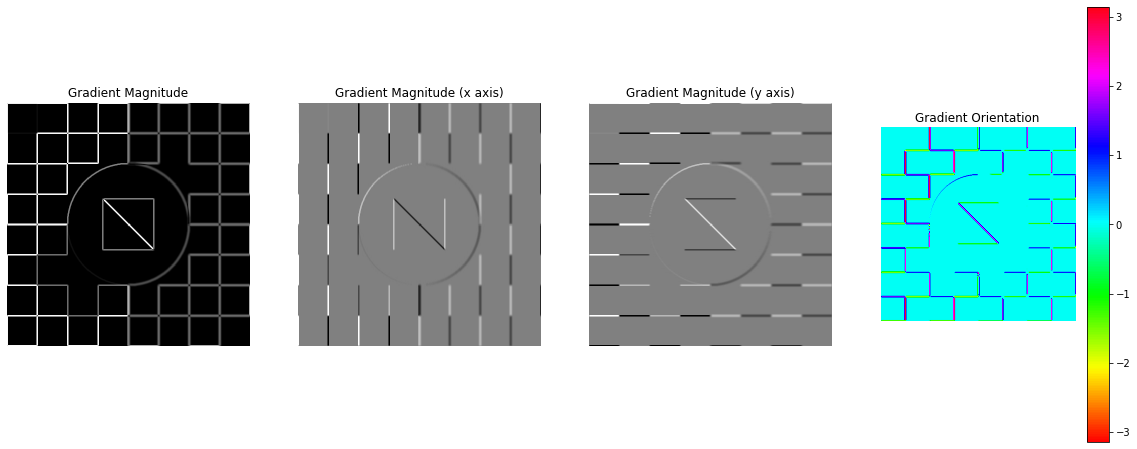

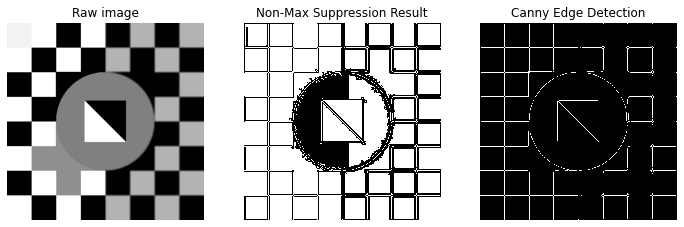

Shape Test Passed! 



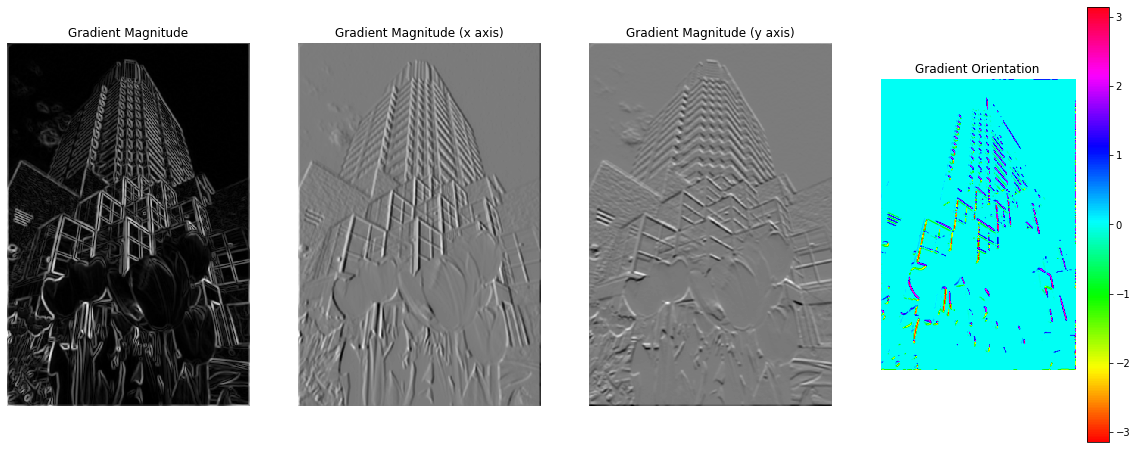

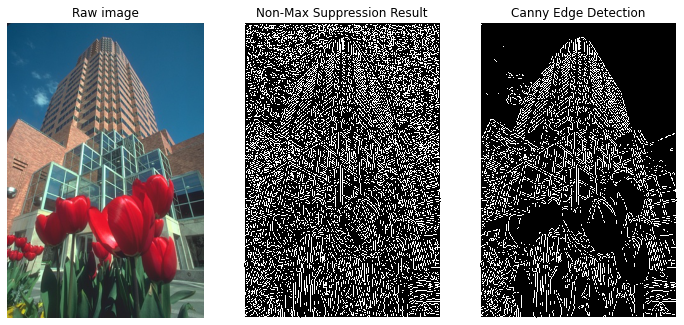

Shape Test Passed! 



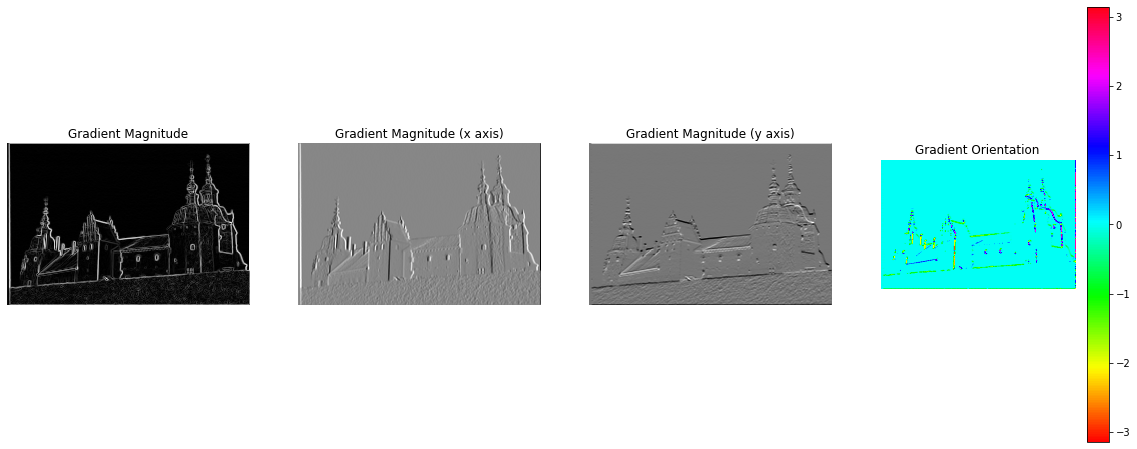

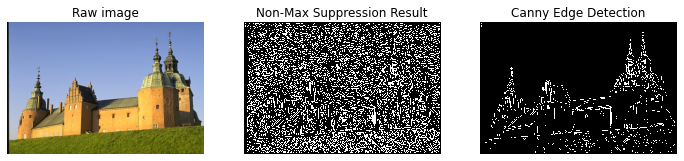

Shape Test Passed! 



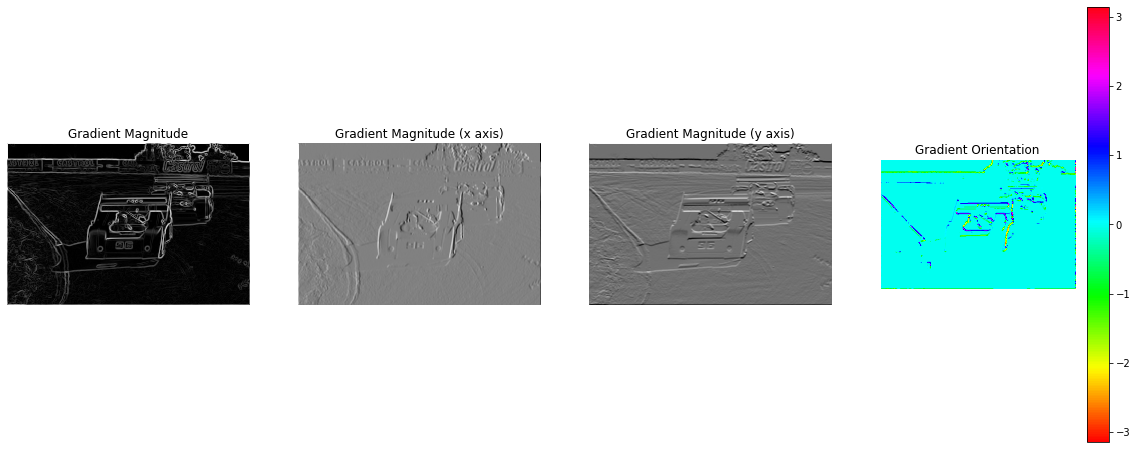

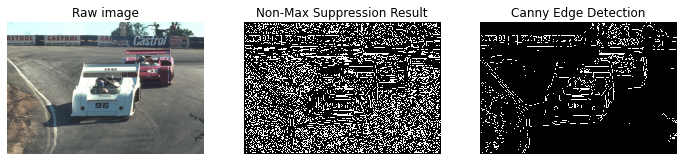

Shape Test Passed! 



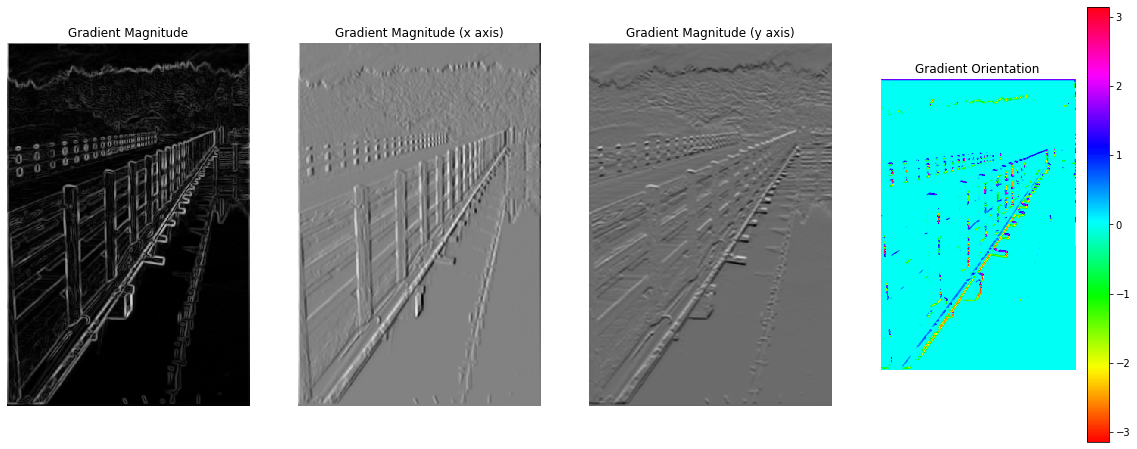

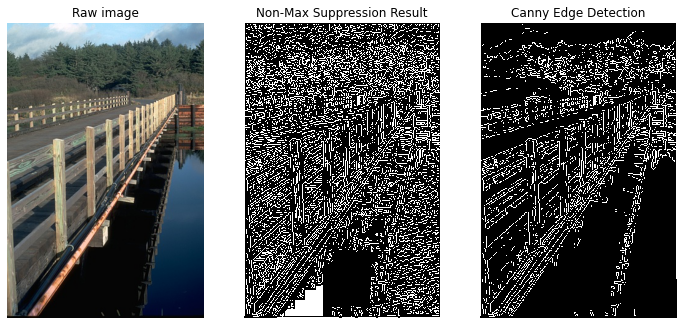

Shape Test Passed! 



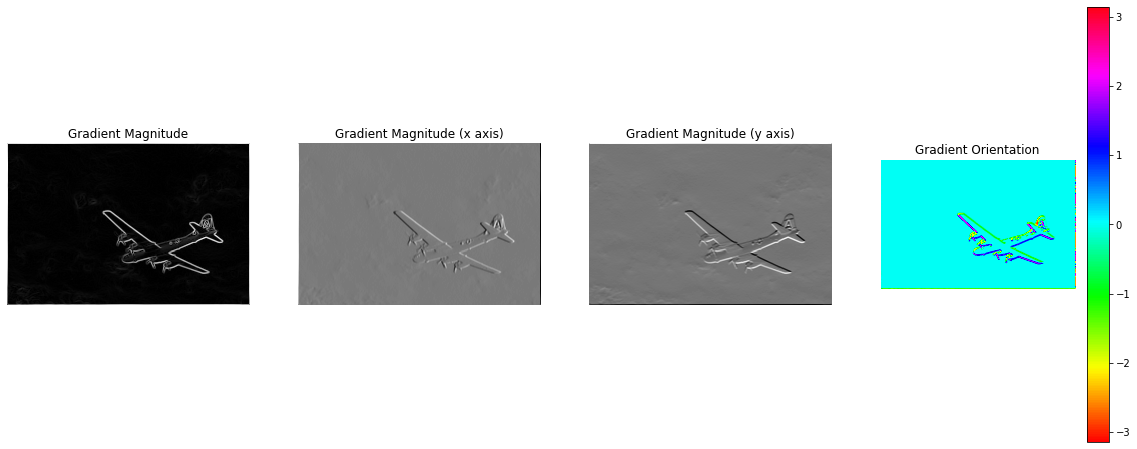

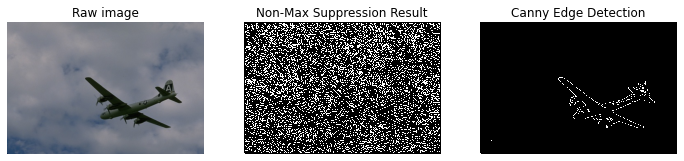

Shape Test Passed! 



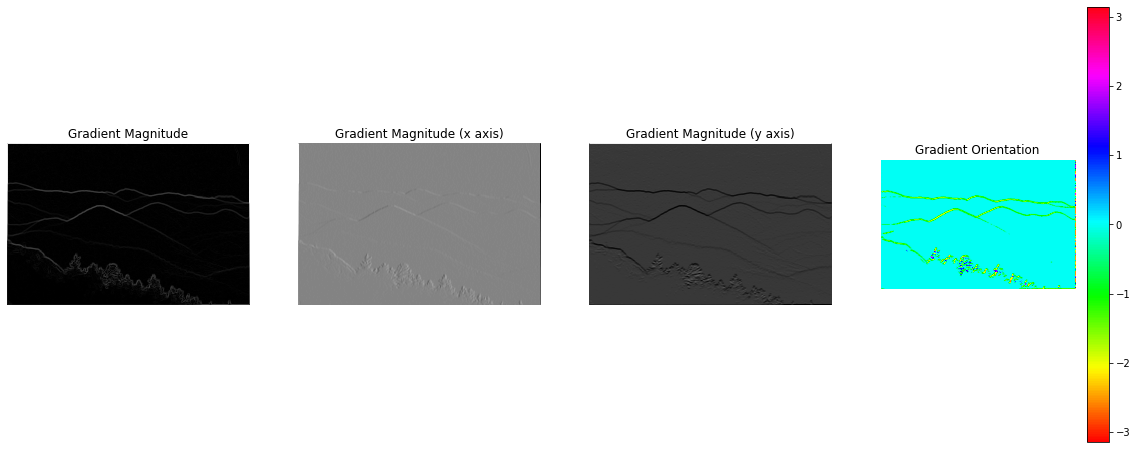

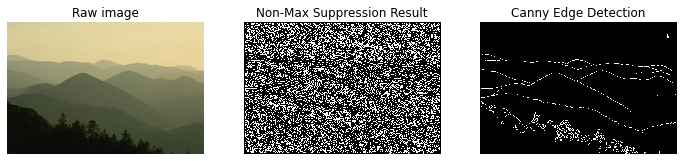

Shape Test Passed! 



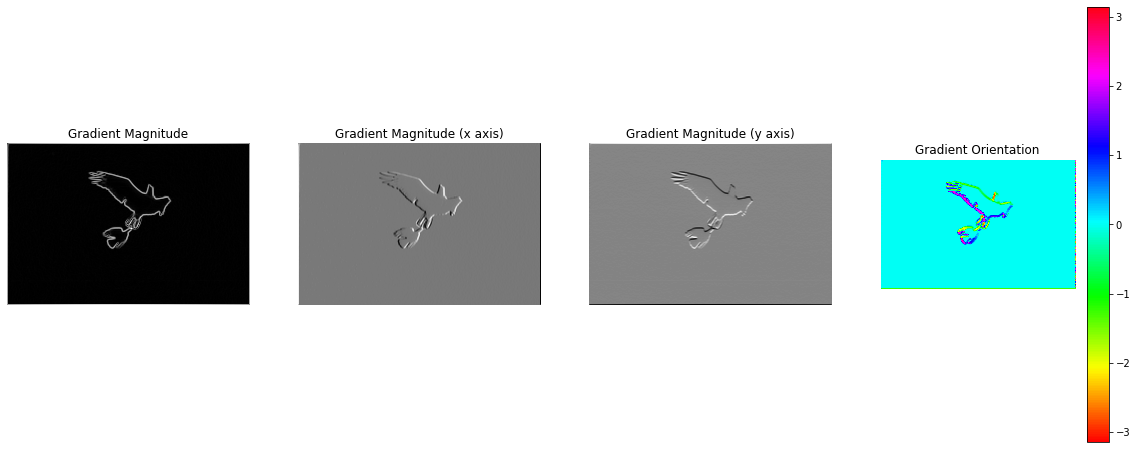

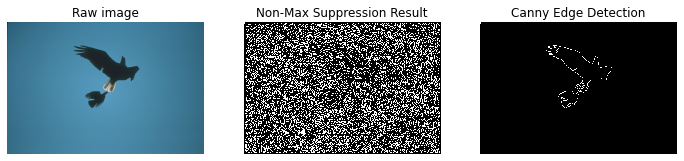

In [ ]:
# keep results for all images
image_folder = "Images"
save_folder = "Results"
# fill in the threshold (low, high) you have tuned in the cell above 
thresh_dict = {'118035.jpg': (1, 4),
                '135069.jpg': (20, 63),
                '16068.jpg': (10, 45),
                '189080.jpg': (9, 43),
                '201080.jpg': (10, 47),
                '21077.jpg': (12, 54),
                '22013.jpg': (15, 30),
                '3096.jpg': (7, 35),
                '48017.jpg': (9, 60),
                '55067.jpg': (5, 12),
                '86000.jpg': (8, 22),
                'I1.jpg': (1, 12)}
# generate results one by one
for filename in os.listdir(image_folder):
    # read in image 
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))
    low, high = thresh_dict[filename]
    E = cannyEdge(I, low, high)
    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))